In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm

# Define Pauli matrices with 1/2 scaling
pauli_x = 0.5 * np.array([[0, 1], [1, 0]], dtype=complex)
pauli_y = 0.5 * np.array([[0, -1j], [1j, 0]], dtype=complex)
pauli_z = 0.5 * np.array([[1, 0], [0, -1]], dtype=complex)


def rotation_matrix(axis: np.ndarray, angle: float) -> np.ndarray:
    """
    Generate a rotation matrix using the exponential of a Pauli matrix.

    Args:
        axis (np.ndarray): A 2x2 matrix representing a linear combination of Pauli matrices.
        angle (float): Rotation angle in radians.

    Returns:
        np.ndarray: A 2x2 unitary rotation matrix.
    """
    return expm(-1j * angle * axis)  # Exponentiate the matrix


def sk1(pulse: dict) -> np.ndarray:
    """
    Build the SK1 composite pulse sequence using rotation matrices.

    Args:
        pulse (dict): Dictionary containing pulse parameters:
            - 'rabiMax' (float): Maximum Rabi frequency.
            - 't' (float): Pulse duration.
            - 'ampError' (np.ndarray): Array of amplitude errors.

    Returns:`
        np.ndarray: A 2x2 unitary matrix representing the SK1 sequence.
    """
    angle = 2 * np.pi * pulse["rabiMax"] * pulse["t"]
    phi = np.arccos(-angle / (4 * np.pi))

    R1 = rotation_matrix(pauli_x, angle * pulse["ampError"][0])

    R2 = np.eye(2, dtype=complex)
    R3 = np.eye(2, dtype=complex)
    for j in range(4):
        axis = np.cos(phi) * pauli_x + np.sin(phi) * pauli_y
        R2 = rotation_matrix(axis, angle * pulse["ampError"][j + 1]) @ R2
        axis = np.cos(-phi) * pauli_x + np.sin(-phi) * pauli_y
        R3 = rotation_matrix(axis, angle * pulse["ampError"][j + 5]) @ R3

    return R3 @ R2 @ R1


def calculate_infid(U1: np.ndarray, U2: np.ndarray) -> float:
    """
    Calculate the infidelity between two unitary matrices in pptt.

    Args:
        U1 (np.ndarray): First 2x2 unitary matrix.
        U2 (np.ndarray): Second 2x2 unitary matrix.

    Returns:
        float: Infidelity (pptt).
    """
    return (1 - np.abs(np.trace(U1 @ U2.T.conj())) / 2) * 1e4


def calculate_pbright(U: np.ndarray, initial_state: np.ndarray) -> float:
    """
    Calculate the probability of being in the bright state.

    Args:
        U (np.ndarray): A 2x2 unitary matrix representing the applied operation.
        initial_state (np.ndarray): The initial state vector (2x1).

    Returns:
        float: Probability of being in the bright state.
    """
    final_state = U @ initial_state
    bright_state = np.array([[0], [1]], dtype=complex)
    return np.abs(bright_state.T.conj() @ final_state) ** 2


def rabi_gate(pulse: dict) -> np.ndarray:
    """
    Calculate the Rabi gate for a given pulse.

    Args:
        pulse (dict): Dictionary containing pulse parameters:
            - 'rabiMax' (float): Maximum Rabi frequency.
            - 't' (float): Pulse duration.
            - 'ampError' (np.ndarray): Array of amplitude errors.

    Returns:
        np.ndarray: A 2x2 unitary matrix representing the Rabi gate.
    """
    angle = 2 * np.pi * pulse["rabiMax"] * pulse["t"]

    U = np.eye(2, dtype=complex)
    for j in range(9):
        U = rotation_matrix(pauli_x, angle * pulse["ampError"][j]) @ U

    return U


def generate_amp_error(ep, kappa, gamma, k):
    """
    Generate amplitude errors based on the error type.
    Args:
        ep (float): Base error.
        kappa (float): Error value for pulse-specific variation.
        gamma (float): Error for linear variation.
        k (int): Error case index (0-4).
    Returns:
        np.ndarray: Array of amplitude errors.
    """
    if k == 0:  # Global pulse error
        return np.ones(9) * (1 + ep)
    elif k == 1:  # First pulse small error
        return np.concatenate([[1 + ep - kappa], np.ones(8) * (1 + ep)])
    elif k == 2:  # Linear error
        return np.linspace(1 - gamma + ep, 1 + gamma + ep, 9)
    elif k == 3:  # Single Rabi gate
        return np.concatenate([[1 + ep], np.zeros(8)])
    elif k == 4:  # no error
        return np.ones(9)


def plot_bars(ax, data, title):
    """
    Plot bar graph with consistent settings.

    Args:
        ax (plt.Axes): The subplot axis to plot on.
        data (np.ndarray): Data for the bar plot.
        title (str): Title of the plot.
    """
    ax.bar(np.arange(1, 10), data, color="None", edgecolor="blue")
    ax.set_xticks(np.arange(1, 10))
    ax.set_xlabel("Pulse Number")
    ax.set_ylim([0.98, 1.02])
    ax.set_title(title)


def plot_annotations(ax, data, ep, gamma, label):
    """
    Plot annotations and reference lines on the graph.

    Args:
        ax (plt.Axes): The subplot axis to plot on.
        data (np.ndarray): Data for the bar plot.
        ep (float): Base error.
        gamma (float): Linear error.
        label (str): Label for the annotation.
    """
    ax.bar(np.arange(1, 10), data, color="None", edgecolor="blue")
    ax.set_xticks(np.arange(1, 10))
    ax.plot(np.arange(0, 11), np.ones(11), linestyle=":")
    ax.plot(np.arange(0, 11), np.ones(11) * (1 + ep), linestyle=":")
    ax.plot(np.arange(1, 10), np.ones(9) * (1 + ep - gamma), linestyle=":")
    ax.annotate(
        "",
        xy=(0, 1),
        xytext=(0, 1 + ep),
        arrowprops=dict(arrowstyle="<->", color="red"),
    )
    ax.text(
        0,
        1.0045,
        "$\epsilon$",
        fontsize=12,
        bbox=dict(facecolor="white", edgecolor="white", alpha=0.5),
    )
    ax.annotate(
        "",
        xy=(10, 1 + ep - gamma),
        xytext=(10, 1 + ep),
        arrowprops=dict(arrowstyle="<->", color="red"),
    )
    ax.text(
        10,
        1.007,
        label,
        fontsize=12,
        bbox=dict(facecolor="white", edgecolor="white", alpha=0.5),
    )
    ax.set_xlabel("Pulse Number")
    ax.set_ylim([0.98, 1.02])

Visualizing the Step and linear error types

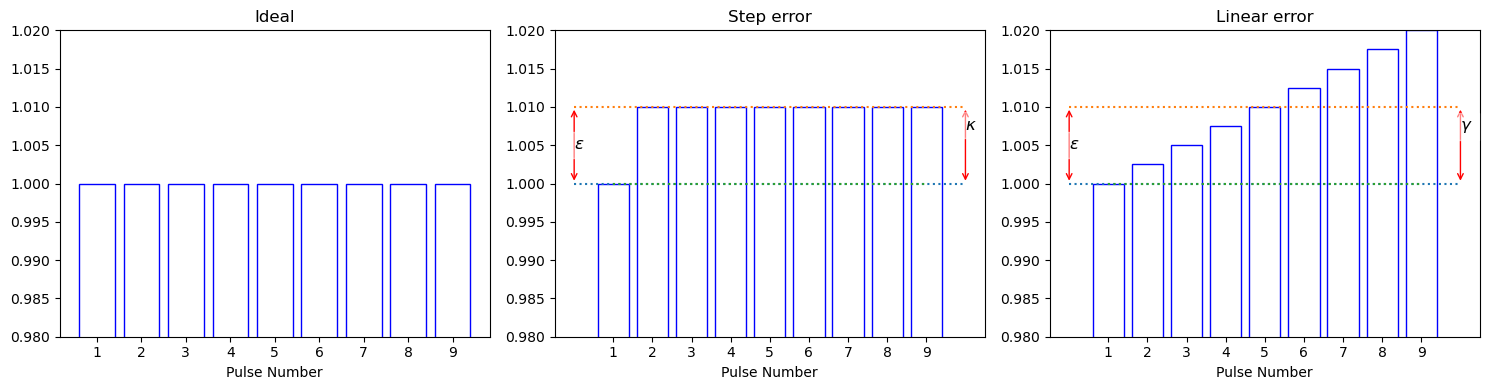

In [2]:
ep = 100e-4
kappa = 100e-4
gamma = 100e-4

amp_ideal = generate_amp_error(ep, kappa, gamma, 4)
amp_fpl = generate_amp_error(ep, kappa, gamma, 1)
amp_linear = generate_amp_error(ep, kappa, gamma, 2)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
plot_bars(axes[0], amp_ideal, "Ideal")
axes[0].set_title("Ideal")
plot_annotations(axes[1], amp_fpl, ep, gamma, "$\kappa$")
axes[1].set_title("Step error")
plot_annotations(axes[2], amp_linear, ep, gamma, "$\gamma$")
axes[2].set_title("Linear error")
plt.tight_layout()

Running Simulation to calculate the effect on fidelity

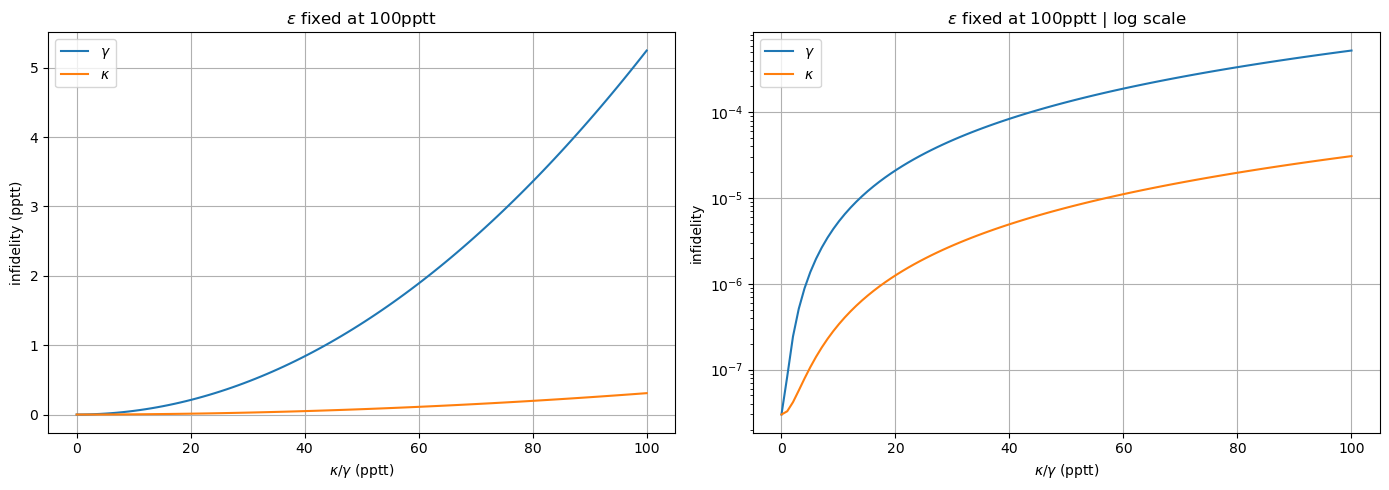

In [3]:
# Define the pulse and parameters
pulse = {"rabiMax": 25e3 / 1.5, "t": 15e-6}  # Pulse parameters
Utarg = rotation_matrix(pauli_x, np.pi / 2)  # Target operator
initial_state = np.array([[0], [1]], dtype=complex)  # Initial state

N = 100
epPPTT = np.linspace(0, 100, N)
ep = 100e-4

infid = []
pbright = []

# Loop through error cases and calculate infidelity and pbright
for k in range(4):
    for j, value in enumerate(epPPTT):
        kappa = value * 1e-4
        gamma = value * 1e-4
        pulse["ampError"] = generate_amp_error(ep, kappa, gamma, k)
        SK1 = sk1(pulse)  # Calculate SK1 sequence
        infid.append(calculate_infid(SK1, Utarg))
        pbright.append(calculate_pbright(SK1, initial_state))


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Log scale plot
axes[1].plot(epPPTT, np.array(infid[2 * N : 3 * N]) * 1e-4, label=r"$\gamma$")
axes[1].plot(epPPTT, np.array(infid[N : 2 * N]) * 1e-4, label=r"$\kappa$")
axes[1].set_xlabel(r"$\kappa / \gamma$ (pptt)")
axes[1].set_title(r"$\epsilon$ fixed at 100pptt | log scale")
axes[1].set_ylabel("infidelity")
axes[1].set_yscale("log")
axes[1].legend(loc="best")
axes[1].grid(True)

# Linear scale plot
axes[0].plot(epPPTT, infid[2 * N : 3 * N], label=r"$\gamma$")
axes[0].plot(epPPTT, infid[N : 2 * N], label=r"$\kappa$")
axes[0].set_xlabel(r"$\kappa / \gamma$ (pptt)")
axes[0].set_ylabel("infidelity (pptt)")
axes[0].set_title(r"$\epsilon$ fixed at 100pptt")
axes[0].legend(loc="best")
axes[0].grid(True)

plt.tight_layout()

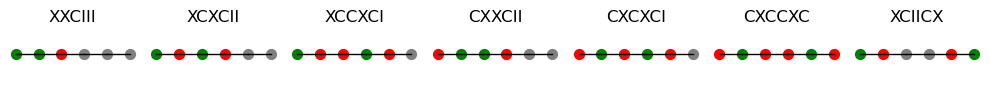

In [4]:
import matplotlib.pyplot as plt

# Define the seven scenarios as strings
scenarios = ["XXCIII", "XCXCII", "XCCXCI", "CXXCII", "CXCXCI", "CXCCXC", "XCIICX"]

# Color mapping for each type of ion
color_map = {"X": "green", "C": "red", "I": "grey"}


def plot_ion_chain(scenario, ax, idx):
    """
    Plot a single ion chain based on the given scenario.

    Args:
        scenario (str): A string of length 6 representing the ion configuration.
        ax (matplotlib.axes.Axes): The subplot axis to draw on.
        idx (int): The scenario index for labeling.
    """
    # Coordinates for the 6 ions in a horizontal line
    x = [1, 2, 3, 4, 5, 6]
    y = [0] * 6  # All on the same line

    # Draw lines connecting the ions
    for i in range(5):
        ax.plot([x[i], x[i + 1]], [y[i], y[i + 1]], "k-", lw=1)

    # Plot each ion with the corresponding color
    for i in range(6):
        ax.scatter(x[i], y[i], s=50, color=color_map[scenario[i]])

    # Add title for each scenario
    ax.set_title(f"{scenario}")

    # Remove axis for a cleaner look
    ax.axis("off")


def plot_all_scenarios():
    """
    Plot all seven scenarios in a grid of subplots.
    """
    fig, axes = plt.subplots(
        1, 7, figsize=(10, 1)
    )  # 3x3 grid (extra space for 7 scenarios)

    # Flatten the axes array for easy indexing
    axes = axes.flatten()

    # Plot each scenario in its own subplot
    for idx, scenario in enumerate(scenarios):
        plot_ion_chain(scenario, axes[idx], idx)

    # Hide any unused subplots (since we only have 7 scenarios)
    for i in range(7, len(axes)):
        axes[i].axis("off")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


# Call the function to plot all scenarios
plot_all_scenarios()

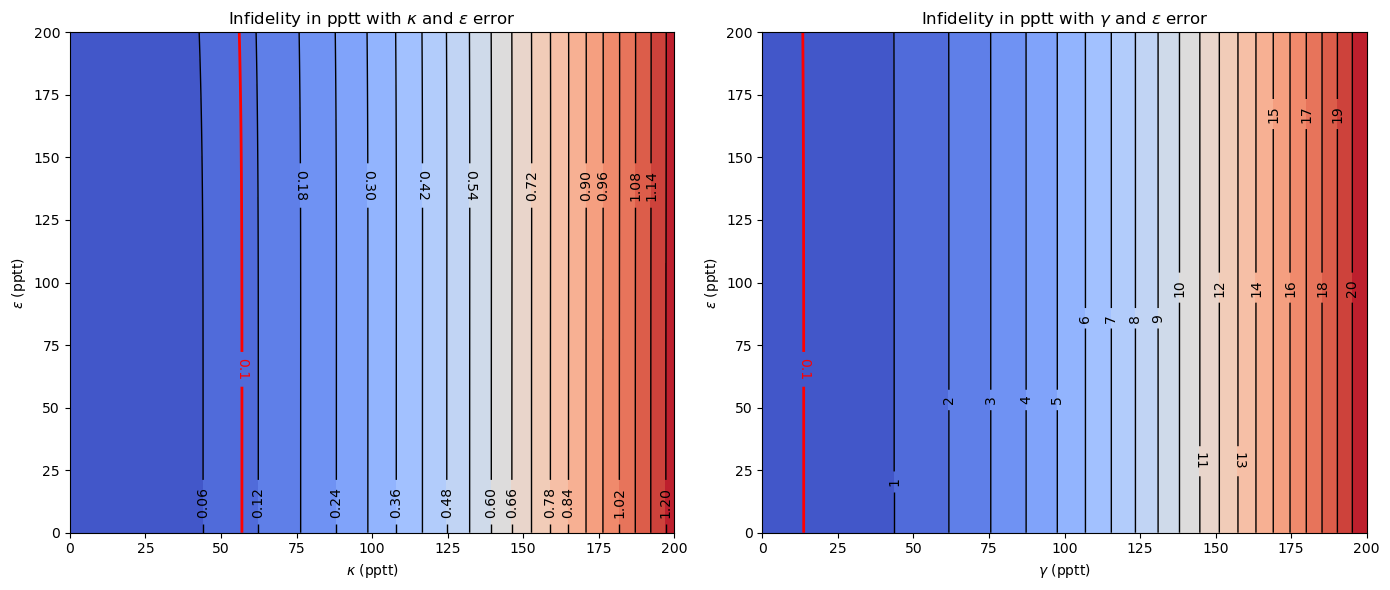

In [5]:
from scipy.interpolate import griddata

# Define the pulse and parameters
pulse = {"rabiMax": 25e3 / 1.5, "t": 15e-6}  # Pulse parameters
Utarg = rotation_matrix(pauli_x, np.pi / 2)  # Target operator
initial_state = np.array([[0], [1]], dtype=complex)  # Initial state

N = 50  # Adjust N for performance
epPPTT = np.linspace(0, 200, N)  # Values for kappa, gamma, and ep
infid_kappa = np.zeros((N, N))  # Infidelity for kappa plot
infid_gamma = np.zeros((N, N))  # Infidelity for gamma plot

# Loop over ep and kappa/gamma to compute infidelity
for ep_idx, ep_value in enumerate(epPPTT):
    ep = ep_value * 1e-4  # Current ep value
    for error_idx, error_value in enumerate(epPPTT):
        kappa = error_value * 1e-4
        gamma = error_value * 1e-4

        # Calculate infidelity for kappa (k=1)
        pulse["ampError"] = generate_amp_error(ep, kappa, gamma, k=1)
        SK1_kappa = sk1(pulse)
        infid_kappa[ep_idx, error_idx] = calculate_infid(SK1_kappa, Utarg)

        # Calculate infidelity for gamma (k=2)
        pulse["ampError"] = generate_amp_error(ep, kappa, gamma, k=2)
        SK1_gamma = sk1(pulse)
        infid_gamma[ep_idx, error_idx] = calculate_infid(SK1_gamma, Utarg)

# Plot labeled contour plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Contour plot: x-axis = kappa, y-axis = ep
X, Y = np.meshgrid(epPPTT, epPPTT)

# Interpolate data to smooth the contour
Z_kappa_interp = griddata(
    (X.ravel(), Y.ravel()), infid_kappa.ravel(), (X, Y), method="cubic"
)
Z_gamma_interp = griddata(
    (X.ravel(), Y.ravel()), infid_gamma.ravel(), (X, Y), method="cubic"
)

# Plot for Kappa
cs1 = axs[0].contourf(X, Y, Z_kappa_interp, levels=20, cmap="coolwarm")
contour_lines1 = axs[0].contour(
    X, Y, Z_kappa_interp, levels=20, colors="black", linewidths=1
)
axs[0].clabel(contour_lines1, inline=True, fontsize=10, colors="black")
# Add contour line for z=0.1
contour_line_kappa_01 = axs[0].contour(
    X, Y, Z_kappa_interp, levels=[0.1], colors="red", linewidths=2
)
axs[0].clabel(contour_line_kappa_01, inline=True, fontsize=10, colors="red")
axs[0].set_xlabel(r"$\kappa$ (pptt)")
axs[0].set_ylabel(r"$\epsilon$ (pptt)")
axs[0].set_title(r"Infidelity in pptt with $\kappa$ and $\epsilon$ error")

# Plot for Gamma
cs2 = axs[1].contourf(X, Y, Z_gamma_interp, levels=20, cmap="coolwarm")
contour_lines2 = axs[1].contour(
    X, Y, Z_gamma_interp, levels=20, colors="black", linewidths=1
)
axs[1].clabel(contour_lines2, inline=True, fontsize=10, colors="black")
# Add contour line for z=0.1
contour_line_gamma_01 = axs[1].contour(
    X, Y, Z_gamma_interp, levels=[0.1], colors="red", linewidths=2
)
axs[1].clabel(contour_line_gamma_01, inline=True, fontsize=10, colors="red")
axs[1].set_xlabel(r"$\gamma$ (pptt)")
axs[1].set_ylabel(r"$\epsilon$ (pptt)")
axs[1].set_title(r"Infidelity in pptt with $\gamma$ and $\epsilon$ error")

# Adjust layout and display plot
plt.tight_layout()
plt.savefig("infidelity_contour.png")
plt.show()